In [ ]:
## Classification of MNIST dataset 
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Random
using Distances
using Flux
using StatsBase
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals.jl")
include("mnist.jl");

In [2]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 10 #Number of samples
c = 10 #Number of classes
d = 784 #Input dimension
N = n*10 #Total samples

#Network hyperparameters
α = 6 #Gamma Scale for Hyperparameters

#Node hyperparameters
k_range = 12 #Maximum number of neurons per layer
k_list = [Int(i) for i in 1:k_range]
k_real = 2

#Layer hyperparameters
l_range = 5 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1

#NUTS
Δmax = 1000;

In [105]:
#Load the MNIST Data
x_total, y_total = load_mnist_test_set()
x_raw = x_total[101:200,:]
y_raw = y_total[101:200]
a = countmap(y_raw)
x = transpose(x_raw)
classes = [float(y_raw[i]) for i=1:length(y_raw)]
size(x)

(784, 100)

In [106]:
print(classes)

[7.0, 1.0, 6.0, 5.0, 10.0, 10.0, 3.0, 2.0, 10.0, 5.0, 9.0, 8.0, 4.0, 10.0, 8.0, 5.0, 5.0, 5.0, 10.0, 3.0, 6.0, 5.0, 8.0, 7.0, 8.0, 10.0, 1.0, 6.0, 9.0, 6.0, 7.0, 7.0, 6.0, 8.0, 9.0, 2.0, 1.0, 2.0, 7.0, 5.0, 7.0, 8.0, 4.0, 2.0, 8.0, 2.0, 9.0, 3.0, 1.0, 3.0, 10.0, 10.0, 6.0, 6.0, 2.0, 6.0, 7.0, 1.0, 4.0, 5.0, 5.0, 7.0, 6.0, 5.0, 7.0, 6.0, 5.0, 6.0, 2.0, 5.0, 5.0, 8.0, 3.0, 4.0, 3.0, 8.0, 2.0, 9.0, 2.0, 9.0, 2.0, 9.0, 6.0, 1.0, 9.0, 10.0, 3.0, 6.0, 1.0, 2.0, 2.0, 2.0, 1.0, 10.0, 1.0, 4.0, 2.0, 7.0, 5.0, 3.0]

In [ ]:
#Run PCA to lower dimensionality of MNIST (later, for now try big params)

In [140]:
hidden_nodes = 10
hidden_array = [0.0 for i=1:hidden_nodes]
hidden_array[hidden_nodes] = 1.0
hidden_array

50-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

In [145]:
#Bayesian Neural Net
function G(x, trace)
    activation = σ
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], c, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], c)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    #l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l ~ categorical([0.0,0.0,0.0,0.0,1.0])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        #k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        k[i] = @trace(categorical(hidden_array), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical(hidden_array), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    α = 0.001 #Gamma Scale for Hyperparameters
    
    ω₁ = 100
    ω₂ = (sum([obs[(:k,i)] for i=1:l]))*100 #Neal (1996): Scaling relationship to # of hidden units
    τ₁ ~ gamma(ω₁,α) #Hidden Weights
    τ₂ ~ gamma(ω₁,α) #Hidden Biases
    τ₃ ~ gamma(ω₂,α) #Output Weights
    #τᵧ ~ gamma(ωᵧ,α) #Noise Parameter for y
    #τ₄ ~ gamma() #Output Biases - Neal uses fixed sigmas here
    
    #Standard Deviations
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σ₃ = 1/τ₃
    #σᵧ = sqrt(1/τᵧ)
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = zeros(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l]*c)
            Σₒ = Diagonal([σ₃ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = zeros(c)
            Σ2ₒ = Diagonal([1.0 for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = logsoftmax(scores,dims=1)
    scores = exp.(scores)
    
    #Logistic Regression Likelihood
    y = zeros(length(scores))
    for j=1:length(x[1,:])
        score_vec = scores[:,j]
        y[j] = @trace(categorical(score_vec), (:y,j))
    end

    return scores
    
end;

(best_trace,) = generate(classifier, (x,), obs)
println(get_score(best_trace))
#println(best_trace[:τ₁])
#println(best_trace[:τ₂])
#println(best_trace[:τ₃])

test = test_scores = classifier(x)
#test_labels = data_labeller(test_scores)
#test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

-Inf


10×100 Array{Float64,2}:
 0.0841577  0.0931607   0.0658435   …  0.0558296   0.132519   0.050614
 0.212359   0.310513    0.320716       0.349499    0.177497   0.331998
 0.0296892  0.0580798   0.062267       0.0511742   0.0954857  0.0470638
 0.0777026  0.0473984   0.0709018      0.0909491   0.0503517  0.0977026
 0.139214   0.113426    0.129589       0.110599    0.284223   0.127723
 0.027247   0.0150686   0.0166037   …  0.0162297   0.0378046  0.020152
 0.0164048  0.013879    0.0141595      0.0127845   0.0172302  0.0141649
 0.0343149  0.0645026   0.0712124      0.0724789   0.0980024  0.0772163
 0.367337   0.276901    0.241098       0.23447     0.0921633  0.226749
 0.0115736  0.00707153  0.00760835     0.00598577  0.0147234  0.00661674

In [ ]:
#--------------------
#RJMCMC - using NUTS
#--------------------
traces = []
scores = []
acc = []

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs_master[:l] = 5
for i = 1:6
    obs_master[(:k, i)] = hidden_nodes
end
obs = obs_master;

function sample_HMC(trace, iters, obs)
    for i=1:iters
        prev_trace = trace
        trace, obs = select_hyperparameters(prev_trace, obs)
        eps = uniform(0.1,1.6)
        selection = select_selection(trace)
        (new_trace, hmc_score) = hmc_mod(trace, selection, L=3, eps=eps, check=false, observations=obs)
        new_score = get_score(new_trace)
        old_score = get_score(prev_trace)
        score = new_score - old_score
        println(score)
        if rand(Uniform(0,1)) < exp(score)
            trace = new_trace
            accepted = 1.0
            #println("Accepted")
        else
            trace = prev_trace
            accepted = 0.0
            #println("Not Accepted")
        end
        push!(traces, trace)
        push!(acc, accepted)
        if i%5 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
    end
    return trace     
end

obs_blank = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_blank[(:y,i)] = classes[i]
end

(starting_trace,) = generate(classifier, (x,), obs)
#get_score(starting_trace)

sample_HMC(starting_trace, 200, obs)

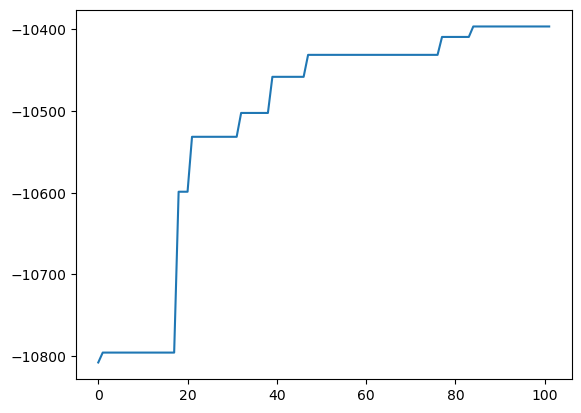

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5279d26fd0>

In [135]:
scores = [get_score(trace) for trace in traces]
plot(scores)

In [138]:
best_trace = traces[:20]
score_test = G(x,best_trace)
scores_test = logsoftmax(score_test,dims=1)
scores_test = exp.(scores_test)
function mnist_labeller(y::Array{Float64})
    labels = [float(argmax(y[:,i])) for i=1:length(classes)]
    return labels
end

labels = mnist_labeller(scores_test)

function mnist_accuracy(labels::Array{Float64},classes::Array{Float64})
    acc = [classes[i] == labels[i] ? 1.0 : 0.0 for i=1:length(classes)]
    total_acc = sum(acc)/length(acc)
    return total_acc
end

mnist_accuracy(labels,classes)

0.1